# Image Classification-CNN Model

### Anggota Kelompok
- Rizky Cahyono Putra
- Raffa Arvel Nafi'Nadindra
- M. Irfansyah
- Galang Fachrezy
- Syaifan Nur Iwawan

Hasil Notebook ini adalah **Klasifikasi Gambar** dari dataset **Intel Image Classification dataset** terbagi menjadi 6 kategori:

1. Buildings  
2. Forest  
3. Glacier  
4. Mountain  
5. Sea  
6. Street  

## Import liberary

Menimport beberapa library

In [1]:
# Basic imports
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn; sn.set(font_scale=1.2)
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm

# Classes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {name: i for i, name in enumerate(class_names)}
nb_classes = len(class_names)

# Image size
IMAGE_SIZE = (150, 150)

# Training epochs
EPOCHS = 20


2025-08-23 14:23:28.989229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755959009.168362      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755959009.227677      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Fungsi untuk Memuat dan Merapikan Data

Kita membuat sebuah fungsi `load_data()` untuk melakukan semua tugas persiapan data secara otomatis. Fungsi ini akan:
- Mengakses folder data training dan data testing.
- Membaca setiap gambar satu per satu.
- Mengubah ukuran semua gambar menjadi **150x150 piksel** agar seragam.
- Mengubah format warna dari BGR ke RGB agar sesuai standar.
- Memberi label angka pada setiap gambar (misalnya, 'forest' menjadi 1, 'sea' menjadi 4).
- **Normalisasi**, yaitu mengubah nilai piksel dari rentang 0-255 menjadi 0-1 agar model lebih mudah belajar.

In [2]:
def load_data():
    datasets = [
        '../input/intel-image-classification/seg_train/seg_train',
        '../input/intel-image-classification/seg_test/seg_test'
    ]
    
    output = []
    
    for dataset in datasets:
        images = []
        labels = []
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(dataset, folder, file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32') / 255.0  # normalize
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
    
    return output


## Load the dataset 

Sekarang kita panggil fungsi `load_data()` yang sudah dibuat. Setelah data berhasil dimuat, kita **mengacak (shuffle)** urutan data training. Tujuannya agar model tidak menghafal urutan data dan bisa belajar lebih baik.

In [3]:
# Load train and test data
(train_images, train_labels), (test_images, test_labels) = load_data()

# Shuffle train data
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

print("Number of training examples:", train_labels.shape[0])
print("Number of testing examples:", test_labels.shape[0])
print("Each image size:", IMAGE_SIZE)

Loading ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:13<00:00, 181.23it/s]


Loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:02<00:00, 203.90it/s]


Number of training examples: 14034
Number of testing examples: 3000
Each image size: (150, 150)


## Visualize random images per class

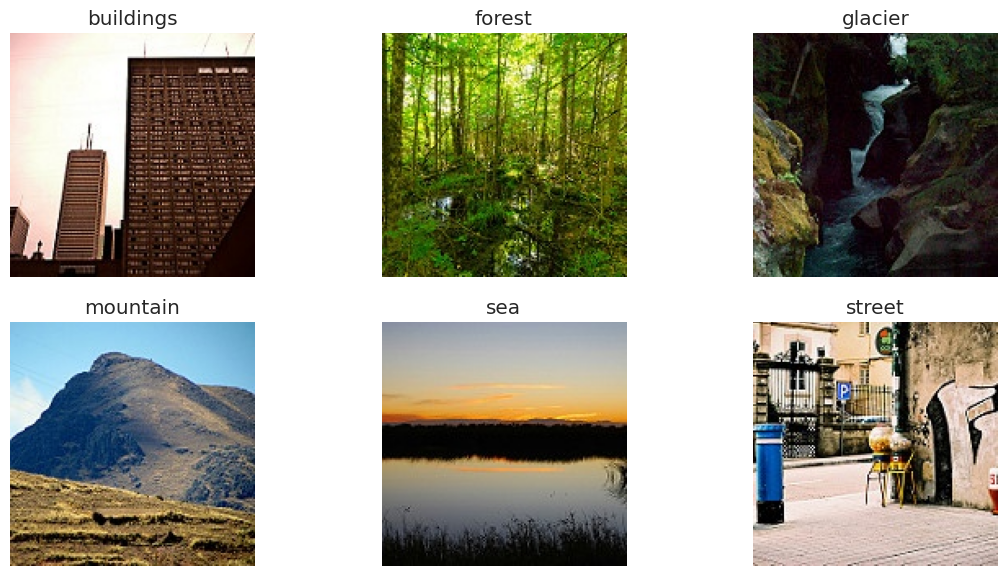

In [4]:
def display_random_image_per_class(class_names, images, labels):
    plt.figure(figsize=(12,6))
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        index = np.random.choice(class_indices)
        plt.subplot(2, 3, i+1)
        plt.imshow(images[index])
        plt.title(class_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_random_image_per_class(class_names, train_images, train_labels)


## Membangun Arsitektur Model CNN 

Di sini, kita akan merancang arsitektur atau "cetak biru" dari model kita dari awal. Bayangkan kita sedang membangun gedung bertingkat:
- **`Conv2D`**: Ini adalah "mata" model kita. Layer ini bertugas mendeteksi pola-pola dasar pada gambar seperti garis, sudut, dan tekstur. Semakin dalam, polanya semakin kompleks.
- **`MaxPooling2D`**: Layer ini berfungsi untuk meringkas informasi, mengambil bagian terpenting dari pola yang ditemukan `Conv2D` dan mengurangi ukuran data.
- **`Flatten`**: Mengubah data yang tadinya berbentuk seperti gambar (2D) menjadi satu baris panjang (1D), agar bisa diproses oleh "otak" model.
- **`Dense`**: Ini adalah "otak" model. Layer ini bertugas mengambil keputusan berdasarkan informasi yang sudah diringkas.
- **`Dropout`**: Teknik untuk mencegah model menjadi "terlalu pintar" atau *overfitting* (hanya hafal data training tapi tidak bisa menebak data baru).
- **`softmax`**: Layer terakhir yang memberikan hasil akhir berupa probabilitas untuk setiap kelas (misalnya, 70% gambar ini adalah 'laut', 20% 'gletser', dst).

Setelah arsitektur siap, kita **compile** model dengan menentukan `optimizer` (cara model belajar), `loss` (cara mengukur kesalahan), dan `metrics` (metrik keberhasilan, yaitu akurasi).

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(nb_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755959115.314517      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816,454 (26.00 MB)

 Trainable params: 6,815,494 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

## Transfer Learning

Selain membuat dari nol, ada cara yang lebih cerdas yaitu **Transfer Learning**. Kita tidak membangun dari awal, tapi memakai model canggih bernama **EfficientNetB0** yang sudah dilatih oleh Google pada jutaan gambar.

Caranya:
1.  **Muat Model EfficientNetB0**: Kita ambil seluruh arsitekturnya, tapi buang layer paling atas (layer klasifikasinya).
2.  **Bekukan (Freeze)**: Kita kunci semua layer yang sudah pintar ini agar tidak berubah saat dilatih ulang.
3.  **Tambahkan "Kepala" Baru**: Kita hanya menambahkan beberapa layer `Dense` baru di bagian atas yang akan kita latih khusus untuk mengenali 6 kelas dataset kita.

Metode ini biasanya jauh lebih cepat dan memberikan akurasi yang lebih tinggi.

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation='softmax')(x)

efficient_model = Model(inputs=base_model.input, outputs=predictions)

efficient_model.compile(optimizer=Adam(1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Train Model

- **`epochs=20`**: Artinya, model akan "mempelajari" seluruh data training sebanyak 20 kali putaran.
- **`validation_data`**: Selama belajar, model akan sesekali "mengerjakan ujian" menggunakan data validasi untuk mengukur sejauh mana kemampuannya pada data yang belum pernah ia lihat.
- **`ReduceLROnPlateau`**: Ini seperti guru yang sabar. Jika nilai model tidak membaik setelah beberapa putaran, "guru" ini akan menurunkan kecepatan belajar agar model bisa belajar lebih teliti.

In [7]:
# Reduce learning rate if val_loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_images, train_labels,
    epochs=EPOCHS,
    validation_data=(test_images, test_labels),
    batch_size=32,
    callbacks=[reduce_lr]
)


Epoch 1/20


I0000 00:00:1755959131.831156      99 service.cc:148] XLA service 0x7ae400007c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755959131.831929      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755959132.309823      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/439 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3336 - loss: 3.0217 

I0000 00:00:1755959136.709647      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.5603 - loss: 1.4858 - val_accuracy: 0.5263 - val_loss: 1.4679 - learning_rate: 1.0000e-04
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7592 - loss: 0.6506 - val_accuracy: 0.7437 - val_loss: 0.7342 - learning_rate: 1.0000e-04
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8044 - loss: 0.5342 - val_accuracy: 0.7920 - val_loss: 0.5847 - learning_rate: 1.0000e-04
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8452 - loss: 0.4269 - val_accuracy: 0.7917 - val_loss: 0.5930 - learning_rate: 1.0000e-04
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8791 - loss: 0.3375 - val_accuracy: 0.7800 - val_loss: 0.6533 - learning_rate: 1.0000e-04
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8997 - loss: 0.2747 - val_accuracy: 0.8390 - val_loss: 0.5119 - learning_rate: 1.0000e-04
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9

## Menganalisis Proses Belajar: Grafik Akurasi & Loss

Setelah training selesai, mari kita lihat "rapor" belajarnya. Kita akan membuat grafik untuk melihat:
- **Grafik Akurasi**: Apakah akurasi model terus meningkat, baik pada data training maupun validasi?
- **Grafik Loss (Kesalahan)**: Apakah tingkat kesalahan model terus menurun?

Grafik ini sangat penting untuk mendeteksi apakah model kita *overfitting* atau tidak.

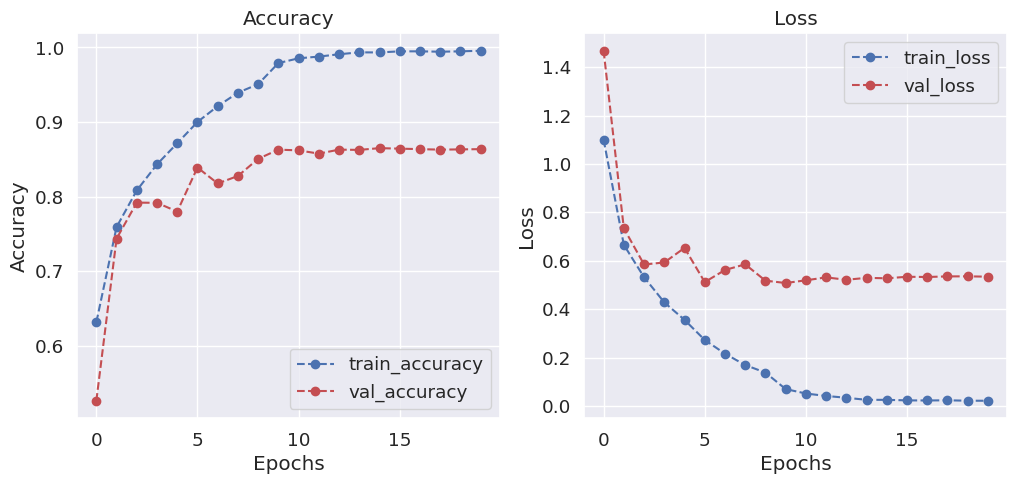

In [8]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], 'bo--', label="train_accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], 'bo--', label="train_loss")
    plt.plot(history.history['val_loss'], 'ro--', label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

plot_accuracy_loss(history)


## Mengevaluasi Hasil Akhir: Confusion Matrix & Laporan Klasifikasi


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


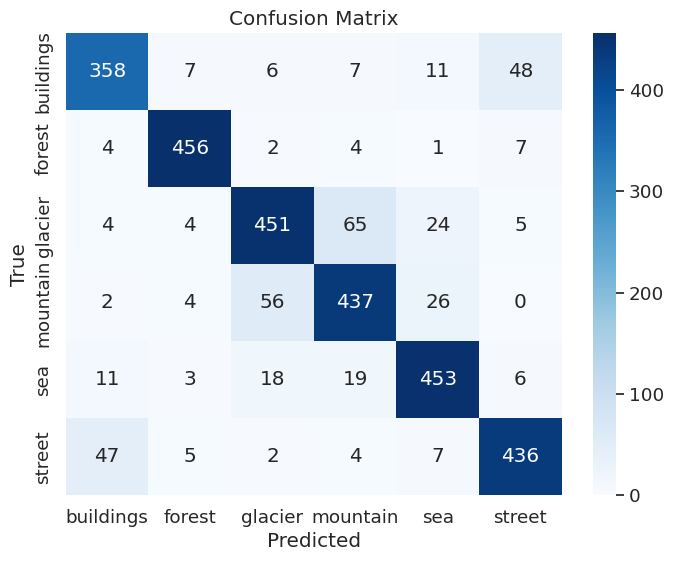

In [9]:
# Predict test images
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Classification report
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.84      0.82      0.83       437
      forest       0.95      0.96      0.96       474
     glacier       0.84      0.82      0.83       553
    mountain       0.82      0.83      0.82       525
         sea       0.87      0.89      0.88       510
      street       0.87      0.87      0.87       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



## Investigasi Kesalahan: Melihat Gambar yang Salah Tebak

Tidak ada model yang sempurna. Mari kita lihat beberapa contoh gambar di mana model kita salah menebak. Ini membantu kita memahami kelemahan model dan mencari cara untuk memperbaikinya di kemudian hari.

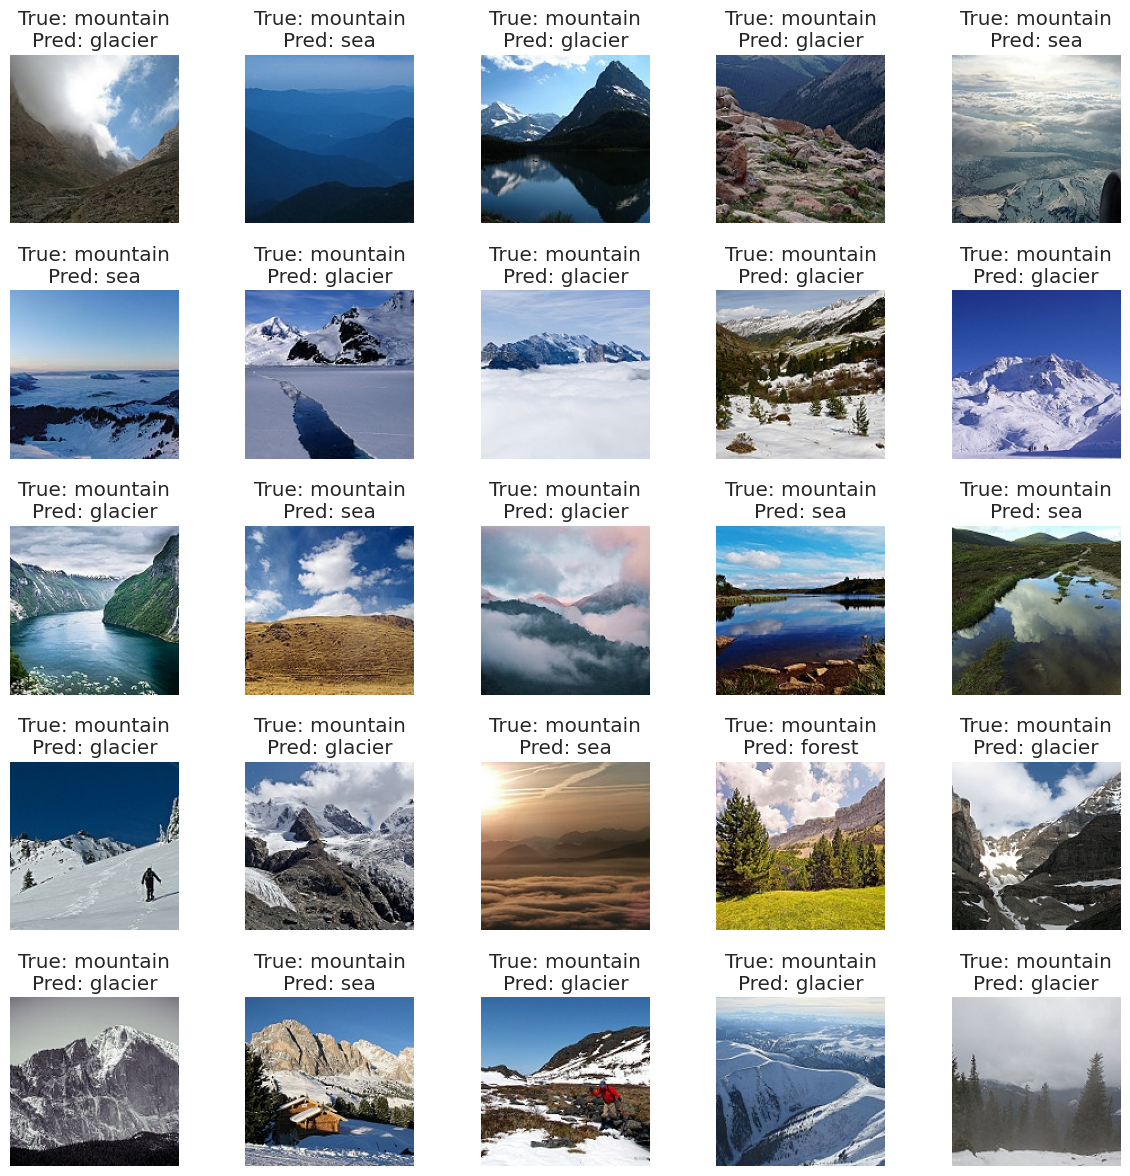

In [11]:
def display_mislabeled(class_names, images, true_labels, pred_labels, n=25):
    mislabeled_indices = np.where(true_labels != pred_labels)[0]
    plt.figure(figsize=(12,12))
    for i in range(min(n, len(mislabeled_indices))):
        idx = mislabeled_indices[i]
        plt.subplot(5,5,i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_mislabeled(class_names, test_images, test_labels, y_pred_classes)
